### Classification Project
### Team 06
### Members

* 202418008
* 202418045
* 202418006
* 202418012

### Problem Formulation

The rating serves as a measure of the fund's overall performance, risk, sustainability, and other financial metrics. We aim to predict the rating of a mutual fund based on various factors related to its investment strategy, financial ratios, historical returns, and ESG (Environmental, Social, and Governance) factors.

### Importing libraries and tools

In [424]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

In [425]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import accuracy_score, classification_report

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')




### Data Acquisition

In [426]:
data = pd.read_csv("Morningstar - European Mutual Funds.csv")

### Exploratory Data Analysis

In [427]:
pdata = pd.read_csv("Morningstar - European Mutual Funds.csv")

Preparing data for EDA

In [428]:
pdata = pdata.drop(['performance_rating'], axis=1)

In [429]:
columns_to_drop = [
    'analyst_rating', 'average_credit_quality', 'modified_duration', 'effective_maturity', 'credit_aaa', 'credit_aa', 
    'credit_a', 'credit_bbb', 'credit_bb', 'credit_b', 'credit_below_b', 'credit_not_rated', 
    'holdings_n_bonds', 'fund_trailing_return_10years'
]

pdata = pdata.drop(columns=columns_to_drop)

In [430]:
pdata = pdata.drop(['equity_style','morningstar_benchmark','fund_benchmark'], axis=1)

In [431]:
pdata['dividend_frequency'] = pdata['dividend_frequency'].str.strip().str.lower()

pdata['dividend_frequency'] = pdata['dividend_frequency'].replace('four times a year', 'quarterly')

In [432]:
from datetime import datetime

pdata['inception_date'] = pd.to_datetime(pdata['inception_date'])

current_date = datetime.now()

pdata['age'] = pdata['inception_date'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

In [433]:
pdata = pdata.drop(['inception_date'], axis=1)

In [434]:
pdata = pdata.dropna(subset=['fund_size_currency'])

In [435]:
exchange_rates = {
    'USD': 1,        
    'JPY': 0.0067,   
    'EUR': 1.1,      
    'DKK': 0.15,     
    'GBP': 1.27,     
    'NOK': 0.093,    
    'CHF': 1.08,     
    'HKD': 0.13,     
    'AUD': 0.64,     
    'SEK': 0.09,     
    'CAD': 0.73,     
    'CNY': 0.14,     
    'CNH': 0.14,     
}

pdata['fund_size_usd'] = pdata.apply(lambda row: row['fund_size'] * exchange_rates.get(row['fund_size_currency'], np.nan), axis=1)

In [436]:
pdata['latest_nav_date'] = pd.to_datetime(pdata['latest_nav_date'])

current_date = datetime.now()

pdata['latest_nav_years_ago'] = pdata['latest_nav_date'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

In [437]:
pdata = pdata.drop(['latest_nav_date'],axis=1)

In [438]:
pdata['cash_flow_growth'] = pdata['cash_flow_growth'].fillna(pdata['cash_flow_growth'].median())
pdata['book_value_growth'] = pdata['book_value_growth'].fillna(pdata['book_value_growth'].median())
pdata['roa'] = pdata['roa'].fillna(pdata['roa'].median())
pdata['roe'] = pdata['roe'].fillna(pdata['roe'].median())
pdata['roic'] = pdata['roic'].fillna(pdata['roic'].median())
pdata['average_coupon_rate'] = pdata['average_coupon_rate'].fillna(pdata['average_coupon_rate'].median())
pdata['sector_basic_materials'] = pdata['sector_basic_materials'].fillna(pdata['sector_basic_materials'].mode()[0])
pdata['sector_consumer_cyclical'] = pdata['sector_consumer_cyclical'].fillna(pdata['sector_consumer_cyclical'].mode()[0])
pdata['sector_financial_services'] = pdata['sector_financial_services'].fillna(pdata['sector_financial_services'].mode()[0])
pdata['sector_real_estate'] = pdata['sector_real_estate'].fillna(pdata['sector_real_estate'].mode()[0])

In [439]:
pdata['equity_style_score'] = pdata['equity_style_score'].fillna(pdata['equity_style_score'].median())
pdata['equity_size_score'] = pdata['equity_size_score'].fillna(pdata['equity_size_score'].median())
pdata['price_prospective_earnings'] = pdata['price_prospective_earnings'].fillna(pdata['price_prospective_earnings'].median())
pdata['price_book_ratio'] = pdata['price_book_ratio'].fillna(pdata['price_book_ratio'].median())
pdata['price_sales_ratio'] = pdata['price_sales_ratio'].fillna(pdata['price_sales_ratio'].median())
pdata['price_cash_flow_ratio'] = pdata['price_cash_flow_ratio'].fillna(pdata['price_cash_flow_ratio'].median())
pdata['dividend_yield_factor'] = pdata['dividend_yield_factor'].fillna(pdata['dividend_yield_factor'].median())
pdata['long_term_projected_earnings_growth'] = pdata['long_term_projected_earnings_growth'].fillna(pdata['long_term_projected_earnings_growth'].median())
pdata['historical_earnings_growth'] = pdata['historical_earnings_growth'].fillna(pdata['historical_earnings_growth'].median())
pdata['sales_growth'] = pdata['sales_growth'].fillna(pdata['sales_growth'].median())

In [440]:
pdata['sector_consumer_defensive'] = pdata['sector_consumer_defensive'].fillna(pdata['sector_consumer_defensive'].mode()[0])
pdata['sector_healthcare'] = pdata['sector_healthcare'].fillna(pdata['sector_healthcare'].mode()[0])
pdata['sector_utilities'] = pdata['sector_utilities'].fillna(pdata['sector_utilities'].mode()[0])
pdata['sector_communication_services'] = pdata['sector_communication_services'].fillna(pdata['sector_communication_services'].mode()[0])
pdata['sector_energy'] = pdata['sector_energy'].fillna(pdata['sector_energy'].mode()[0])
pdata['sector_industrials'] = pdata['sector_industrials'].fillna(pdata['sector_industrials'].mode()[0])
pdata['sector_technology'] = pdata['sector_technology'].fillna(pdata['sector_technology'].mode()[0])
pdata['market_cap_giant'] = pdata['market_cap_giant'].fillna(pdata['market_cap_giant'].mode()[0])
pdata['market_cap_large'] = pdata['market_cap_large'].fillna(pdata['market_cap_large'].mode()[0])
pdata['market_cap_medium'] = pdata['market_cap_medium'].fillna(pdata['market_cap_medium'].mode()[0])

In [441]:
pdata['market_cap_small'] = pdata['market_cap_small'].fillna(pdata['market_cap_small'].mode()[0])
pdata['market_cap_micro'] = pdata['market_cap_micro'].fillna(pdata['market_cap_micro'].mode()[0])

pdata['holdings_n_stock'] = pdata['holdings_n_stock'].fillna(pdata['holdings_n_stock'].median())
pdata['ongoing_cost'] = pdata['ongoing_cost'].fillna(pdata['ongoing_cost'].median())
pdata['management_fees'] = pdata['management_fees'].fillna(pdata['management_fees'].median())

pdata['environmental_score'] = pdata['environmental_score'].fillna(pdata['environmental_score'].median())
pdata['social_score'] = pdata['social_score'].fillna(pdata['social_score'].median())
pdata['governance_score'] = pdata['governance_score'].fillna(pdata['governance_score'].median())
pdata['sustainability_score'] = pdata['sustainability_score'].fillna(pdata['sustainability_score'].median())
pdata['sustainability_rank'] = pdata['sustainability_rank'].fillna(pdata['sustainability_rank'].median())

In [442]:
pdata['sustainability_percentage_rank'] = pdata['sustainability_percentage_rank'].fillna(pdata['sustainability_percentage_rank'].median())

involvement_columns = [
    'involvement_abortive_contraceptive',
    'involvement_alcohol',
    'involvement_animal_testing',
    'involvement_controversial_weapons',
    'involvement_gambling',
    'involvement_gmo',
    'involvement_military_contracting',
    'involvement_nuclear',
    'involvement_palm_oil'
]

for column in involvement_columns:
    pdata[column] = pdata[column].fillna(pdata[column].mode()[0])  

In [443]:
involvement_columns = [
    'involvement_pesticides',
    'involvement_small_arms',
    'involvement_thermal_coal',
    'involvement_tobacco'
]

for column in involvement_columns:
    pdata[column] = pdata[column].fillna(pdata[column].mode()[0])

pdata['shareclass_size'] = pdata['shareclass_size'].fillna(pdata['shareclass_size'].mode()[0])

pdata['fund_trailing_return_ytd'] = pdata['fund_trailing_return_ytd'].fillna(pdata['fund_trailing_return_ytd'].median())
pdata['fund_trailing_return_3years'] = pdata['fund_trailing_return_3years'].fillna(pdata['fund_trailing_return_3years'].median())
pdata['fund_trailing_return_5years'] = pdata['fund_trailing_return_5years'].fillna(pdata['fund_trailing_return_5years'].median())
pdata['fund_return_2019'] = pdata['fund_return_2019'].fillna(pdata['fund_return_2019'].median())
pdata['fund_return_2018'] = pdata['fund_return_2018'].fillna(pdata['fund_return_2018'].median())

In [444]:
return_columns = [
    'fund_return_2017',
    'fund_return_2016',
    'fund_return_2015',
    'fund_return_2020_q3',
    'fund_return_2020_q2',
    'fund_return_2020_q1',
    'fund_return_2019_q4',
    'fund_return_2019_q3',
    'fund_return_2019_q2',
    'fund_return_2019_q1'
]

for column in return_columns:
    pdata[column] = pdata[column].fillna(pdata[column].median())

In [445]:
additional_return_columns = [
    'fund_return_2018_q4',
    'fund_return_2018_q3',
    'fund_return_2018_q2',
    'fund_return_2018_q1',
    'fund_return_2017_q4',
    'fund_return_2017_q3',
    'fund_return_2017_q2',
    'fund_return_2017_q1',
    'fund_return_2016_q4',
    'fund_return_2016_q3',
    'fund_return_2016_q2',
    'fund_return_2016_q1',
    'fund_return_2015_q4',
    'fund_return_2015_q3',
    'fund_return_2015_q2',
    'fund_return_2015_q1'
]

for column in additional_return_columns:
    pdata[column] = pdata[column].fillna(pdata[column].median())  

In [446]:
pdata = pdata.drop_duplicates(subset=['fund_name'])

In [447]:
label_cols = ['investment_managers', 'category', 'fund_name', 'investment_strategy','dividend_frequency','bond_interest_rate_sensitivity','bond_credit_quality','country_exposure','nav_per_share_currency','shareclass_size_currency','top5_regions','top5_holdings','equity_size']

le = LabelEncoder()

for col in label_cols:
    pdata[col] = le.fit_transform(pdata[col])

In [448]:
columns_to_cap = [
    'risk_rating', 'price_book_ratio', 'price_sales_ratio',
    'dividend_yield_factor', 'historical_earnings_growth',
    'sales_growth', 'book_value_growth', 'roa', 'roe', 'roic', 'holdings_n_stock', 'ongoing_cost',
    'management_fees', 'sustainability_score',
    'quarters_up', 'quarters_down', 'age',
]

def cap_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

pdata = cap_outliers(pdata, columns_to_cap)

In [449]:
pdata.nunique().sort_values(ascending = True)[0:15]

equity_size                        4
bond_credit_quality                4
bond_interest_rate_sensitivity     4
rating                             5
risk_rating                        5
sustainability_rank                5
dividend_frequency                 6
latest_nav_years_ago               7
fund_size_currency                14
quarters_down                     15
age                               20
shareclass_size_currency          23
nav_per_share_currency            23
quarters_up                       24
holdings_n_stock                  70
dtype: int64

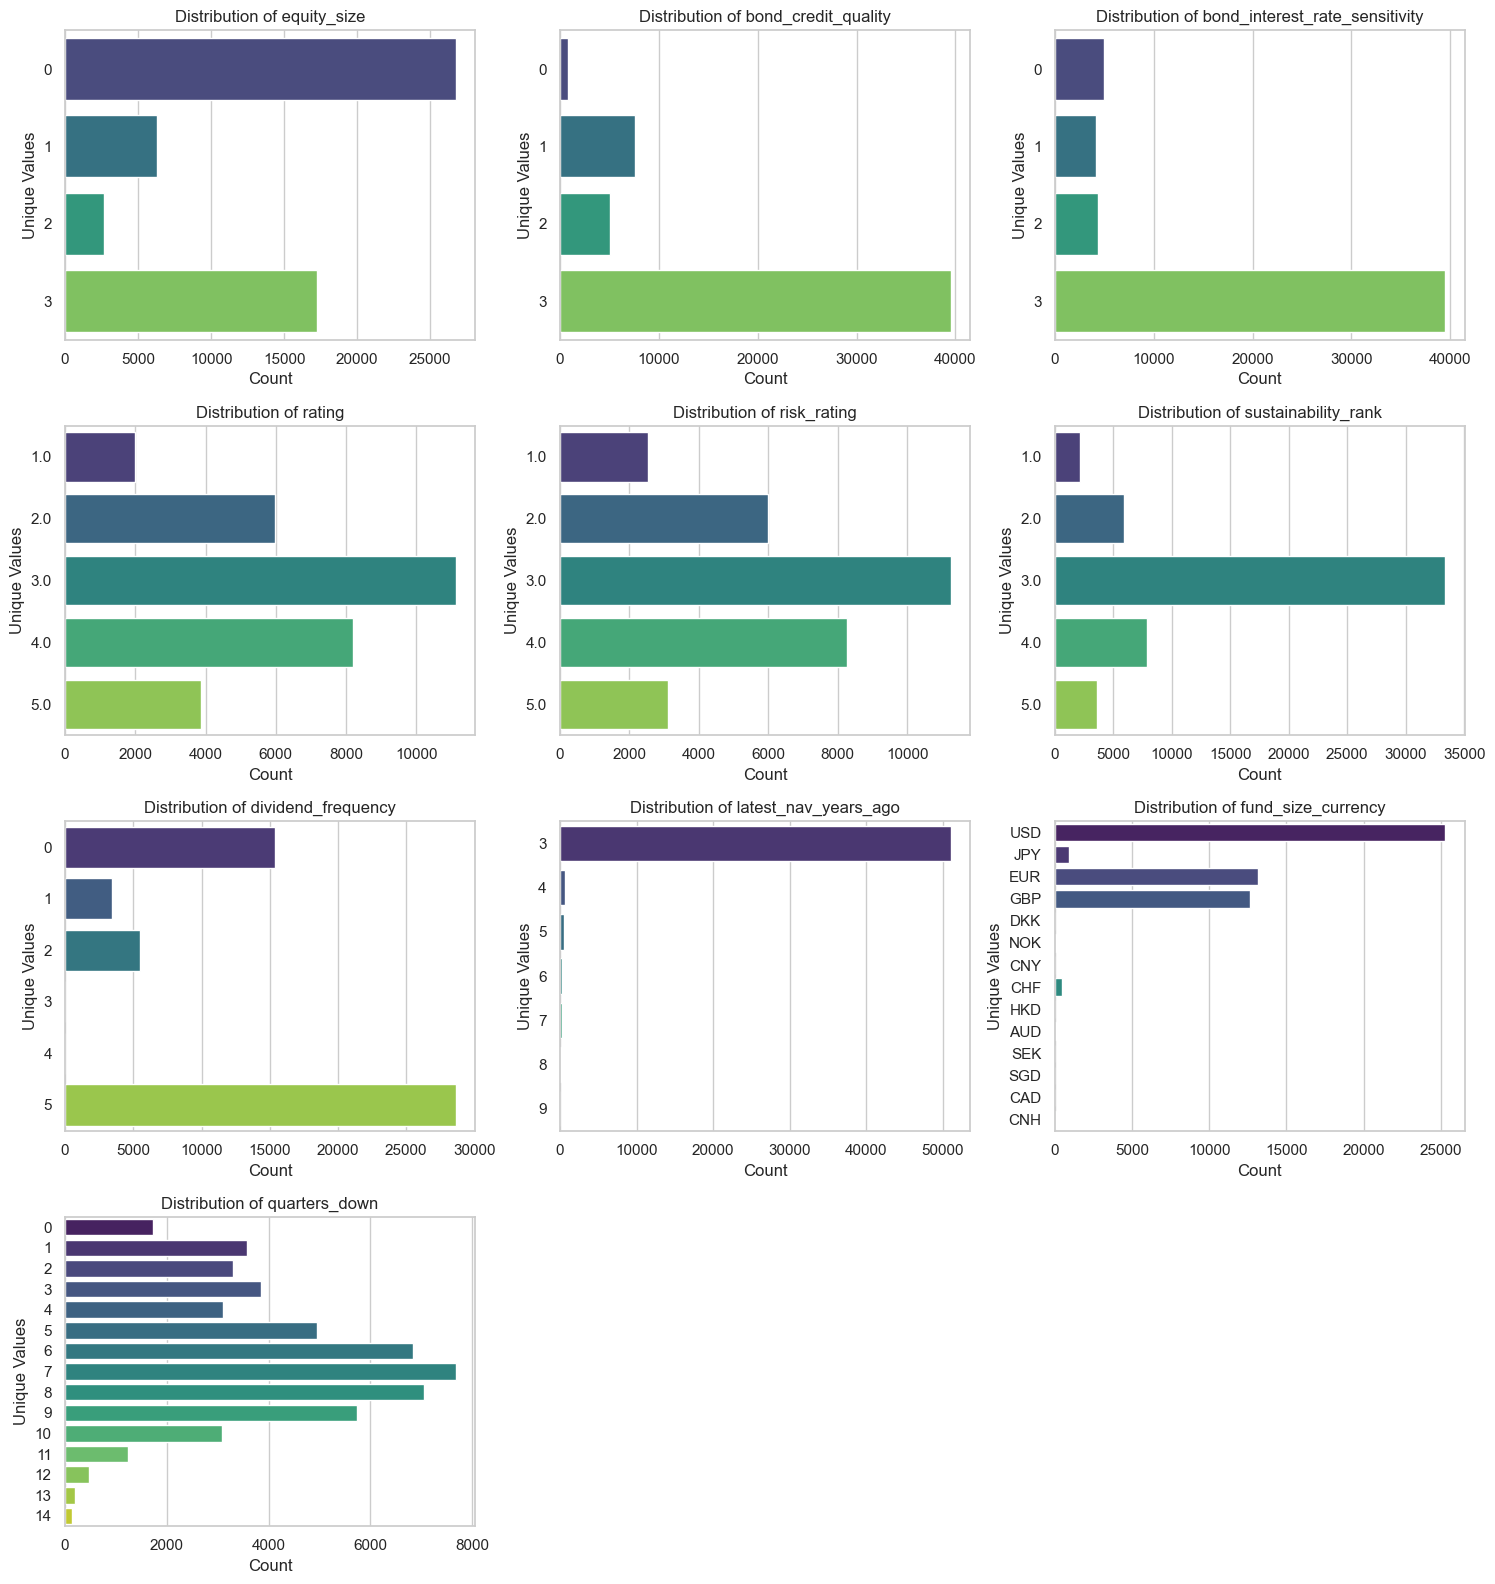

In [450]:
unique_counts = pdata.nunique().sort_values(ascending=True)[0:10]

n_cols = 3  
n_rows = (len(unique_counts) // n_cols) + 1  


fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  

for i, column in enumerate(unique_counts.index):
    sns.countplot(y=pdata[column], ax=axes[i], palette="viridis")
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_ylabel('Unique Values')
    axes[i].set_xlabel('Count')

for i in range(len(unique_counts), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

The visualizations highlight the distribution of key variables. The most notable insight is the imbalance in the rating distribution, which could negatively impact model performance if not addressed. Techniques like SMOTE (Synthetic Minority Over-sampling Technique) can help by generating synthetic samples to balance the classes, ensuring that the model learns from a more evenly distributed dataset. This will improve the model's ability to generalize, especially for the minority classes in the ratings.

### Data Pre-Processing

In [451]:
data.head()

,ticker,isin,fund_name,inception_date,category,rating,analyst_rating,risk_rating,performance_rating,investment_strategy,...,fund_return_2016_q4,fund_return_2016_q3,fund_return_2016_q2,fund_return_2016_q1,fund_return_2015_q4,fund_return_2015_q3,fund_return_2015_q2,fund_return_2015_q1,quarters_up,quarters_down
0,0P00000BOW,LU0011983433,Morgan Stanley Investment Funds - Global Bond ...,1989-11-01,Global Bond,5.0,NaN,3.0,5.0,The Global Bond Fund's investment objective is...,...,-2.06,5.32,10.26,7.52,2.22,3.68,-7.67,3.27,16,7
1,0P00000ESH,LU0757425763,Threadneedle (Lux) - American Select Class AU ...,2000-07-28,US Large-Cap Growth Equity,2.0,NaN,3.0,2.0,The American Select Portfolio seeks to achieve...,...,8.94,8.33,8.67,0.46,8.85,-3.70,-4.42,5.90,17,6
2,0P00000ESL,LU0011818076,HSBC Global Investment Funds - Economic Scale ...,1987-01-16,Japan Large-Cap Equity,2.0,NaN,1.0,2.0,The sub-fund aims to provide long term total r...,...,6.77,13.15,7.59,-3.61,12.00,-8.66,-1.15,14.08,14,9
3,0P00000FI7,LU0152882725,Capital Group Global Equity Fund (LUX) B,2000-10-06,Global Large-Cap Growth Equity,2.0,NaN,2.0,2.0,Long-term capital growth through investment pr...,...,4.61,9.14,6.83,0.67,8.47,-6.78,-4.57,7.70,18,5
4,0P00000FIA,LU0114999294,Capital Group Global Equity Fund (LUX) B,2000-10-06,Global Large-Cap Growth Equity,2.0,NaN,2.0,2.0,Long-term capital growth through investment pr...,...,4.41,9.66,6.28,0.82,8.18,-6.99,-4.39,7.31,18,5


In [452]:
data.shape

(57603, 132)

In [453]:
duplicate_count = data.duplicated().sum()
duplicate_count

0

We dropped the rows with nan value in rating column because we want to take rating as a label

In [454]:
data.dropna(subset=['rating'], inplace=True)

In [455]:
data.shape

(34361, 132)

These two columns are used to identify mutual funds and they won't be relevant in predicting their ratings, so we dropped them

In [456]:
data = data.drop(['ticker', 'isin'], axis=1)

In [457]:
columns_to_check = [
    'analyst_rating', 'average_credit_quality', 'modified_duration', 'effective_maturity', 'credit_aaa', 'credit_aa', 
    'credit_a', 'credit_bbb', 'credit_bb', 'credit_b', 'credit_below_b', 'credit_not_rated', 
    'holdings_n_bonds', 'fund_trailing_return_10years'
]

nan_counts = data[columns_to_check].isna().sum()
print(nan_counts)

analyst_rating                  28091
average_credit_quality          24169
modified_duration               28280
effective_maturity              26476
credit_aaa                      24173
credit_aa                       24173
credit_a                        24173
credit_bbb                      24173
credit_bb                       24173
credit_b                        24173
credit_below_b                  24173
credit_not_rated                24173
holdings_n_bonds                18985
fund_trailing_return_10years    19140
dtype: int64


We have 34361 rows in the database and these columns have enough nan columns to ignore them, so we will drop them

In [458]:
columns_to_drop = [
    'analyst_rating', 'average_credit_quality', 'modified_duration', 'effective_maturity', 'credit_aaa', 'credit_aa', 
    'credit_a', 'credit_bbb', 'credit_bb', 'credit_b', 'credit_below_b', 'credit_not_rated', 
    'holdings_n_bonds', 'fund_trailing_return_10years'
]

data = data.drop(columns=columns_to_drop)

In [459]:
data.head()

,fund_name,inception_date,category,rating,risk_rating,performance_rating,investment_strategy,investment_managers,dividend_frequency,fund_benchmark,...,fund_return_2016_q4,fund_return_2016_q3,fund_return_2016_q2,fund_return_2016_q1,fund_return_2015_q4,fund_return_2015_q3,fund_return_2015_q2,fund_return_2015_q1,quarters_up,quarters_down
0,Morgan Stanley Investment Funds - Global Bond ...,1989-11-01,Global Bond,5.0,3.0,5.0,The Global Bond Fund's investment objective is...,"James Caron, Christian Roth, Michael Kushma, R...",NaN,BBgBarc Global Aggregate TR USD,...,-2.06,5.32,10.26,7.52,2.22,3.68,-7.67,3.27,16,7
1,Threadneedle (Lux) - American Select Class AU ...,2000-07-28,US Large-Cap Growth Equity,2.0,3.0,2.0,The American Select Portfolio seeks to achieve...,Ashish Kochar,NaN,S&P 500 TR USD,...,8.94,8.33,8.67,0.46,8.85,-3.70,-4.42,5.90,17,6
2,HSBC Global Investment Funds - Economic Scale ...,1987-01-16,Japan Large-Cap Equity,2.0,1.0,2.0,The sub-fund aims to provide long term total r...,NaN,Annually,MSCI Japan NR USD,...,6.77,13.15,7.59,-3.61,12.00,-8.66,-1.15,14.08,14,9
3,Capital Group Global Equity Fund (LUX) B,2000-10-06,Global Large-Cap Growth Equity,2.0,2.0,2.0,Long-term capital growth through investment pr...,"Philip Winston, William Robbins, Gregory Fuss,...",NaN,MSCI World NR USD,...,4.61,9.14,6.83,0.67,8.47,-6.78,-4.57,7.70,18,5
4,Capital Group Global Equity Fund (LUX) B,2000-10-06,Global Large-Cap Growth Equity,2.0,2.0,2.0,Long-term capital growth through investment pr...,"Philip Winston, William Robbins, Gregory Fuss,...",NaN,MSCI World NR USD,...,4.41,9.66,6.28,0.82,8.18,-6.99,-4.39,7.31,18,5


These columns are irrelevant for predicting the rating of mutual funds:
* equity style is redundant because there are other features like category and investment strategy
* morningstar benchmark and fund benchmark show performance of the fund benchmark, they do not give any information about the fund itself

In [460]:
data = data.drop(['equity_style','morningstar_benchmark','fund_benchmark'], axis=1)

In [461]:
data.shape

(34361, 113)

performance_rating             0.933048
fund_trailing_return_3years    0.483653
fund_trailing_return_5years    0.449352
fund_trailing_return_ytd       0.408132
price_book_ratio               0.306827
equity_style_score             0.288031
fund_return_2019_q2            0.273731
fund_return_2020_q1            0.269385
fund_return_2020_q3            0.239817
sustainability_rank            0.235418
fund_return_2019               0.207007
fund_return_2018               0.199312
fund_return_2019_q3            0.183456
book_value_growth              0.180406
sector_technology              0.174822
Name: rating, dtype: float64


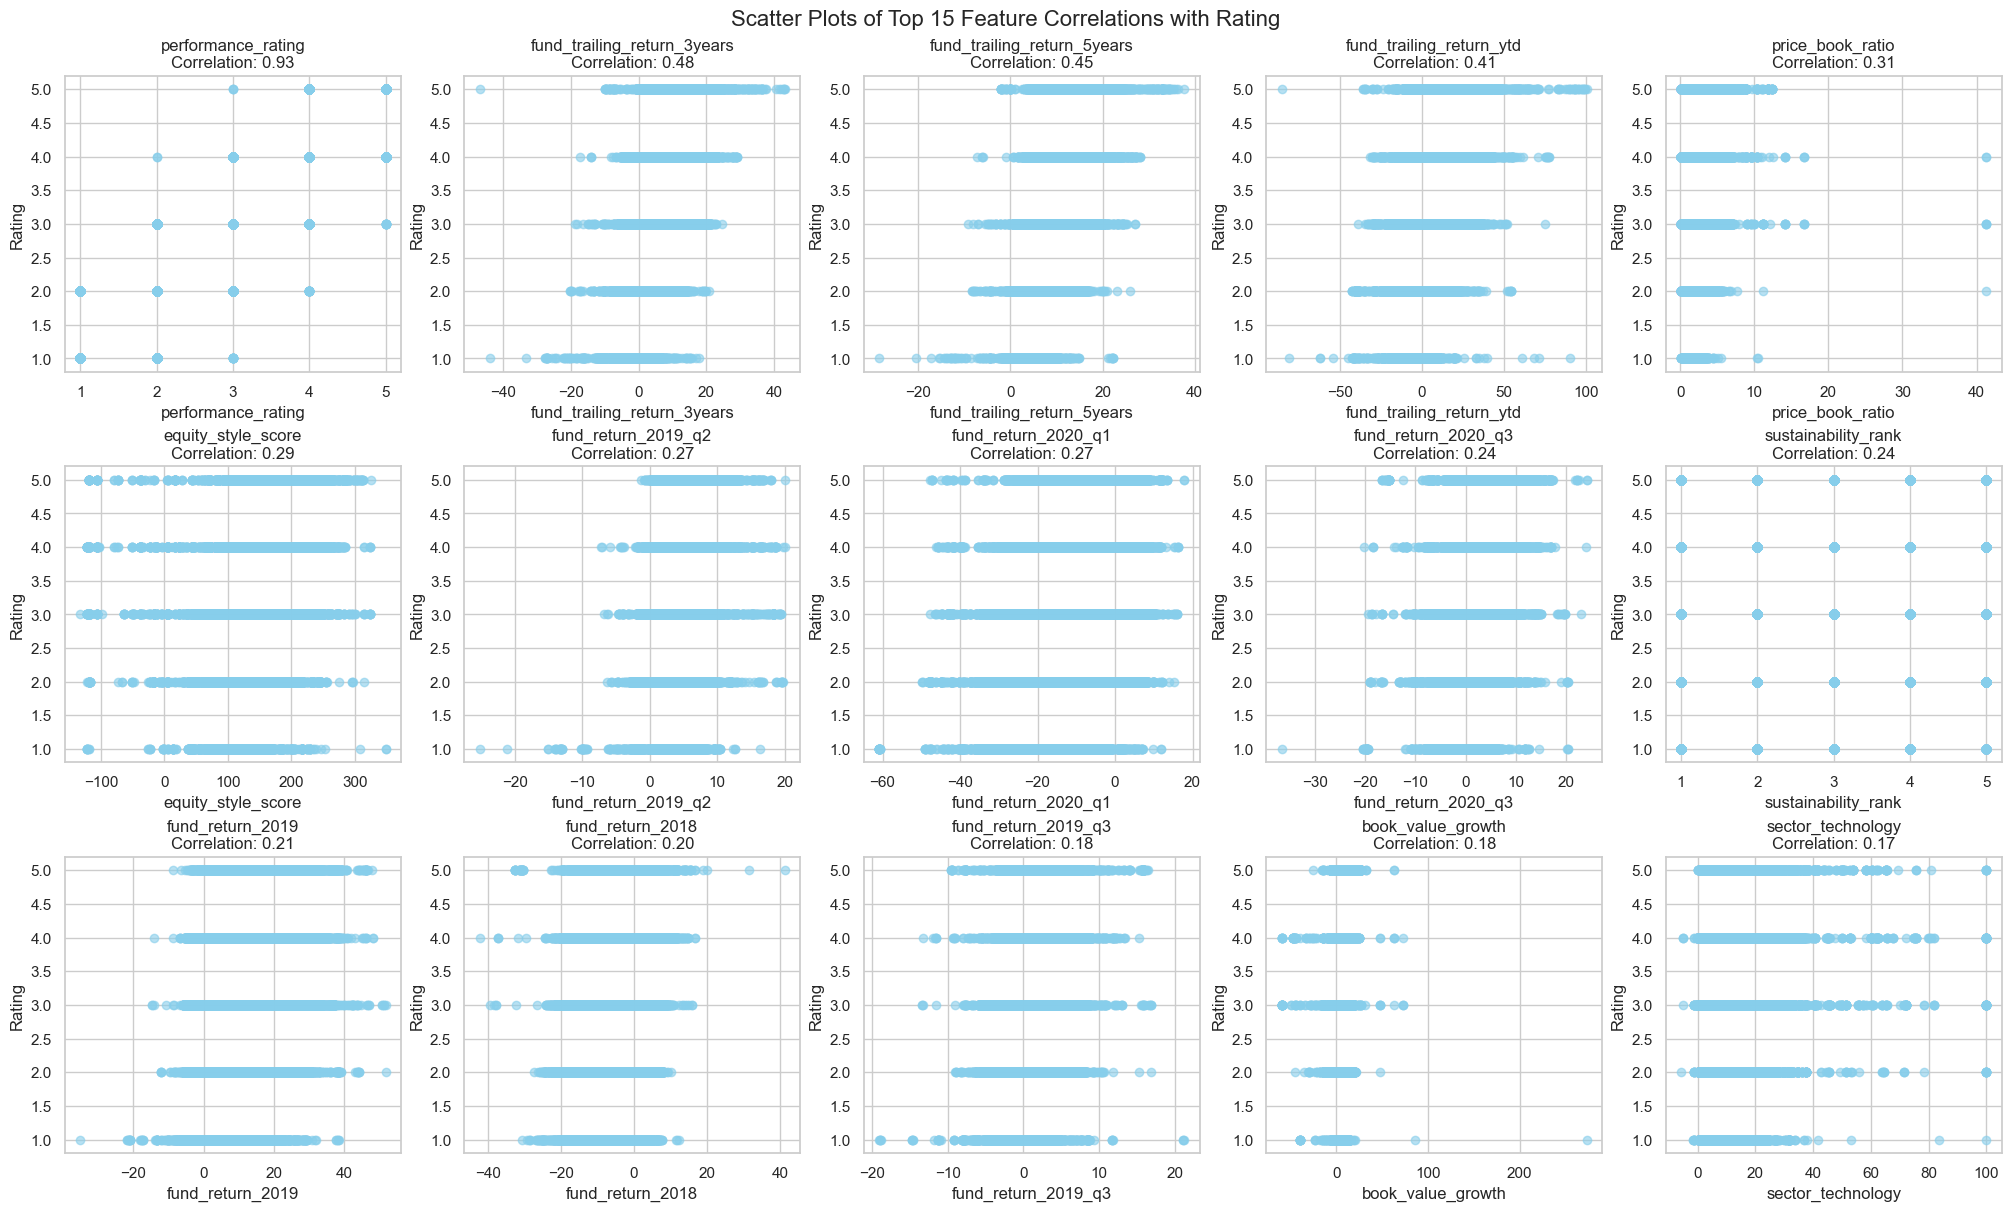

In [462]:
numeric_data = data.select_dtypes(include=['number'])

correlations = numeric_data.corr()['rating'].sort_values(ascending=False)

top_15_correlations = correlations[1:16]

print(top_15_correlations)

fig, axes = plt.subplots(3, 5, figsize=(20, 12), constrained_layout=True)

for i, (feature, correlation) in enumerate(top_15_correlations.items()):
    row = i // 5
    col = i % 5 
    
    axes[row, col].scatter(numeric_data[feature], numeric_data['rating'], alpha=0.6, color='skyblue')
    
    axes[row, col].set_title(f'{feature}\nCorrelation: {correlation:.2f}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Rating')

fig.suptitle('Scatter Plots of Top 15 Feature Correlations with Rating', fontsize=16)

plt.show()

In [463]:
correlation = data['performance_rating'].corr(data['rating'])
print(f"Correlation between performance_rating and rating: {correlation}")

Correlation between performance_rating and rating: 0.9330481243950726


From the graphs we observe, The performance rating variable has a very strong correlation (0.93) with the target variable (rating), while other features show weak to moderate correlations, indicating non-linear relationships. To avoid over-reliance on the dominant feature (performance rating) and potential overfitting, we've wisely shifted to tree-based models, which can better handle complex interactions among the remaining features. Dropping performance rating allows the model to leverage other features more effectively.

In [464]:
data = data.drop(['performance_rating'], axis=1)

In [465]:
data.shape

(34361, 112)

In [466]:
data['dividend_frequency'].unique()

array([nan, 'Annually', 'Monthly', 'Quarterly', 'Four times a year',
       'Weekly'], dtype=object)

Here Four times a year and quaterly mean the same thing so we will merge them together

In [467]:
data['dividend_frequency'] = data['dividend_frequency'].str.strip().str.lower()

data['dividend_frequency'] = data['dividend_frequency'].replace('four times a year', 'quarterly')

In [468]:
data['dividend_frequency'].unique()

array([nan, 'annually', 'monthly', 'quarterly', 'weekly'], dtype=object)

In [469]:
from datetime import datetime

data['inception_date'] = pd.to_datetime(data['inception_date'])

current_date = datetime.now()

data['age'] = data['inception_date'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

The inception date by itself is not very useful so we derived the age because age of the mutual funds might be useful to predict the rating

In [470]:
data = data.drop(['inception_date'], axis=1)

In [471]:
data.head()

,fund_name,category,rating,risk_rating,investment_strategy,investment_managers,dividend_frequency,equity_style_score,equity_size,equity_size_score,...,fund_return_2016_q3,fund_return_2016_q2,fund_return_2016_q1,fund_return_2015_q4,fund_return_2015_q3,fund_return_2015_q2,fund_return_2015_q1,quarters_up,quarters_down,age
0,Morgan Stanley Investment Funds - Global Bond ...,Global Bond,5.0,3.0,The Global Bond Fund's investment objective is...,"James Caron, Christian Roth, Michael Kushma, R...",NaN,16.43,Small,42.89,...,5.32,10.26,7.52,2.22,3.68,-7.67,3.27,16,7,34
1,Threadneedle (Lux) - American Select Class AU ...,US Large-Cap Growth Equity,2.0,3.0,The American Select Portfolio seeks to achieve...,Ashish Kochar,NaN,187.85,Large,332.11,...,8.33,8.67,0.46,8.85,-3.70,-4.42,5.90,17,6,24
2,HSBC Global Investment Funds - Economic Scale ...,Japan Large-Cap Equity,2.0,1.0,The sub-fund aims to provide long term total r...,NaN,annually,94.85,Large,262.64,...,13.15,7.59,-3.61,12.00,-8.66,-1.15,14.08,14,9,37
3,Capital Group Global Equity Fund (LUX) B,Global Large-Cap Growth Equity,2.0,2.0,Long-term capital growth through investment pr...,"Philip Winston, William Robbins, Gregory Fuss,...",NaN,164.14,Large,297.60,...,9.14,6.83,0.67,8.47,-6.78,-4.57,7.70,18,5,24
4,Capital Group Global Equity Fund (LUX) B,Global Large-Cap Growth Equity,2.0,2.0,Long-term capital growth through investment pr...,"Philip Winston, William Robbins, Gregory Fuss,...",NaN,164.14,Large,297.60,...,9.66,6.28,0.82,8.18,-6.99,-4.39,7.31,18,5,24


In [472]:
data = data.dropna(subset=['fund_size_currency'])

In [473]:
exchange_rates = {
    'USD': 1,        
    'JPY': 0.0067,   
    'EUR': 1.1,      
    'DKK': 0.15,     
    'GBP': 1.27,     
    'NOK': 0.093,    
    'CHF': 1.08,     
    'HKD': 0.13,     
    'AUD': 0.64,     
    'SEK': 0.09,     
    'CAD': 0.73,     
    'CNY': 0.14,     
    'CNH': 0.14,     
}

data['fund_size_usd'] = data.apply(lambda row: row['fund_size'] * exchange_rates.get(row['fund_size_currency'], np.nan), axis=1)

In [474]:
data = data.drop(['fund_size_currency','fund_size'],axis=1)

The column fund_size has values in different currencies so we converted them to usd and created a new column called fund_size_usd, we also then dropped fund_size and fund_size_currency 

In [475]:
data.shape

(33856, 111)

In [476]:
data['latest_nav_date'] = pd.to_datetime(data['latest_nav_date'])

current_date = datetime.now()

data['latest_nav_years_ago'] = data['latest_nav_date'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

In [477]:
data = data.drop(['latest_nav_date'],axis=1)

The duration of time might be more of use to predict rating then simply the date of when the nav was updated

Dealing with nan values in columns
We imputed mean, median and mode of all the values in the respective column in them

In [478]:
data['equity_style_score'] = data['equity_style_score'].fillna(data['equity_style_score'].median())
data['equity_size_score'] = data['equity_size_score'].fillna(data['equity_size_score'].median())
data['price_prospective_earnings'] = data['price_prospective_earnings'].fillna(data['price_prospective_earnings'].median())
data['price_book_ratio'] = data['price_book_ratio'].fillna(data['price_book_ratio'].median())
data['price_sales_ratio'] = data['price_sales_ratio'].fillna(data['price_sales_ratio'].median())
data['price_cash_flow_ratio'] = data['price_cash_flow_ratio'].fillna(data['price_cash_flow_ratio'].median())
data['dividend_yield_factor'] = data['dividend_yield_factor'].fillna(data['dividend_yield_factor'].median())
data['long_term_projected_earnings_growth'] = data['long_term_projected_earnings_growth'].fillna(data['long_term_projected_earnings_growth'].median())
data['historical_earnings_growth'] = data['historical_earnings_growth'].fillna(data['historical_earnings_growth'].median())
data['sales_growth'] = data['sales_growth'].fillna(data['sales_growth'].median())

In [479]:
data['cash_flow_growth'] = data['cash_flow_growth'].fillna(data['cash_flow_growth'].median())
data['book_value_growth'] = data['book_value_growth'].fillna(data['book_value_growth'].median())
data['roa'] = data['roa'].fillna(data['roa'].median())
data['roe'] = data['roe'].fillna(data['roe'].median())
data['roic'] = data['roic'].fillna(data['roic'].median())
data['average_coupon_rate'] = data['average_coupon_rate'].fillna(data['average_coupon_rate'].median())
data['sector_basic_materials'] = data['sector_basic_materials'].fillna(data['sector_basic_materials'].mode()[0])
data['sector_consumer_cyclical'] = data['sector_consumer_cyclical'].fillna(data['sector_consumer_cyclical'].mode()[0])
data['sector_financial_services'] = data['sector_financial_services'].fillna(data['sector_financial_services'].mode()[0])
data['sector_real_estate'] = data['sector_real_estate'].fillna(data['sector_real_estate'].mode()[0])

In [480]:
data['sector_consumer_defensive'] = data['sector_consumer_defensive'].fillna(data['sector_consumer_defensive'].mode()[0])
data['sector_healthcare'] = data['sector_healthcare'].fillna(data['sector_healthcare'].mode()[0])
data['sector_utilities'] = data['sector_utilities'].fillna(data['sector_utilities'].mode()[0])
data['sector_communication_services'] = data['sector_communication_services'].fillna(data['sector_communication_services'].mode()[0])
data['sector_energy'] = data['sector_energy'].fillna(data['sector_energy'].mode()[0])
data['sector_industrials'] = data['sector_industrials'].fillna(data['sector_industrials'].mode()[0])
data['sector_technology'] = data['sector_technology'].fillna(data['sector_technology'].mode()[0])
data['market_cap_giant'] = data['market_cap_giant'].fillna(data['market_cap_giant'].mode()[0])
data['market_cap_large'] = data['market_cap_large'].fillna(data['market_cap_large'].mode()[0])
data['market_cap_medium'] = data['market_cap_medium'].fillna(data['market_cap_medium'].mode()[0])

In [481]:
data['market_cap_small'] = data['market_cap_small'].fillna(data['market_cap_small'].mode()[0])
data['market_cap_micro'] = data['market_cap_micro'].fillna(data['market_cap_micro'].mode()[0])

data['holdings_n_stock'] = data['holdings_n_stock'].fillna(data['holdings_n_stock'].median())
data['ongoing_cost'] = data['ongoing_cost'].fillna(data['ongoing_cost'].median())
data['management_fees'] = data['management_fees'].fillna(data['management_fees'].median())

data['environmental_score'] = data['environmental_score'].fillna(data['environmental_score'].median())
data['social_score'] = data['social_score'].fillna(data['social_score'].median())
data['governance_score'] = data['governance_score'].fillna(data['governance_score'].median())
data['sustainability_score'] = data['sustainability_score'].fillna(data['sustainability_score'].median())
data['sustainability_rank'] = data['sustainability_rank'].fillna(data['sustainability_rank'].median())

In [482]:
data['sustainability_percentage_rank'] = data['sustainability_percentage_rank'].fillna(data['sustainability_percentage_rank'].median())

involvement_columns = [
    'involvement_abortive_contraceptive',
    'involvement_alcohol',
    'involvement_animal_testing',
    'involvement_controversial_weapons',
    'involvement_gambling',
    'involvement_gmo',
    'involvement_military_contracting',
    'involvement_nuclear',
    'involvement_palm_oil'
]

for column in involvement_columns:
    data[column] = data[column].fillna(data[column].mode()[0])

In [483]:
involvement_columns = [
    'involvement_pesticides',
    'involvement_small_arms',
    'involvement_thermal_coal',
    'involvement_tobacco'
]

for column in involvement_columns:
    data[column] = data[column].fillna(data[column].mode()[0])

data['shareclass_size'] = data['shareclass_size'].fillna(data['shareclass_size'].mode()[0])

data['fund_trailing_return_ytd'] = data['fund_trailing_return_ytd'].fillna(data['fund_trailing_return_ytd'].median())
data['fund_trailing_return_3years'] = data['fund_trailing_return_3years'].fillna(data['fund_trailing_return_3years'].median())
data['fund_trailing_return_5years'] = data['fund_trailing_return_5years'].fillna(data['fund_trailing_return_5years'].median())
data['fund_return_2019'] = data['fund_return_2019'].fillna(data['fund_return_2019'].median())
data['fund_return_2018'] = data['fund_return_2018'].fillna(data['fund_return_2018'].median())

In [484]:
return_columns = [
    'fund_return_2017',
    'fund_return_2016',
    'fund_return_2015',
    'fund_return_2020_q3',
    'fund_return_2020_q2',
    'fund_return_2020_q1',
    'fund_return_2019_q4',
    'fund_return_2019_q3',
    'fund_return_2019_q2',
    'fund_return_2019_q1'
]

for column in return_columns:
    data[column] = data[column].fillna(data[column].median())


In [485]:
additional_return_columns = [
    'fund_return_2018_q4',
    'fund_return_2018_q3',
    'fund_return_2018_q2',
    'fund_return_2018_q1',
    'fund_return_2017_q4',
    'fund_return_2017_q3',
    'fund_return_2017_q2',
    'fund_return_2017_q1',
    'fund_return_2016_q4',
    'fund_return_2016_q3',
    'fund_return_2016_q2',
    'fund_return_2016_q1',
    'fund_return_2015_q4',
    'fund_return_2015_q3',
    'fund_return_2015_q2',
    'fund_return_2015_q1'
]

for column in additional_return_columns:
    data[column] = data[column].fillna(data[column].median())  

We dropped the duplicate of fund names as they are the same funds and same funds can't have different ratings or features

In [486]:
data = data.drop_duplicates(subset=['fund_name'])

Label encoding features that have many values that are repeating. We did not to one hot encoding because there were many unique values so one hot encoding would massively increase features

In [487]:
label_cols = ['investment_managers', 'category', 'fund_name', 'investment_strategy','dividend_frequency','bond_interest_rate_sensitivity','bond_credit_quality','country_exposure','nav_per_share_currency','shareclass_size_currency','top5_regions','top5_holdings','equity_size']

le = LabelEncoder()

for col in label_cols:
    data[col] = le.fit_transform(data[col])

### Feature Engineeering

We derived features from the database and created new more useful features and then we dropped the original comments

In [488]:
new_columns = {
    
    'mean_return_last_3years': data[['fund_trailing_return_3years', 'fund_return_2020_q3', 'fund_return_2019_q3']].mean(axis=1),
    'std_dev_returns': data[['fund_return_2020_q3', 'fund_return_2019_q3', 'fund_return_2018_q3']].std(axis=1),
    'yoy_change': data['fund_return_2020_q3'] - data['fund_return_2019_q3'],

    'cyclical_sector_exposure': data[['sector_consumer_cyclical', 'sector_energy', 'sector_basic_materials']].sum(axis=1),
    'defensive_sector_exposure': data[['sector_consumer_defensive', 'sector_healthcare', 'sector_utilities']].sum(axis=1),

    'prop_giant_caps': data['market_cap_giant'] / data[['market_cap_giant', 'market_cap_large', 'market_cap_medium', 'market_cap_small', 'market_cap_micro']].sum(axis=1),
    'prop_small_caps': data['market_cap_small'] / data[['market_cap_giant', 'market_cap_large', 'market_cap_medium', 'market_cap_small', 'market_cap_micro']].sum(axis=1),

    'pe_vs_growth': data['price_prospective_earnings'] / data['long_term_projected_earnings_growth'],
    'pcf_vs_growth': data['price_cash_flow_ratio'] / data['cash_flow_growth'],

    'avg_esg_score': data[['environmental_score', 'social_score', 'governance_score']].mean(axis=1),
    'esg_variability': data[['environmental_score', 'social_score', 'governance_score']].std(axis=1),

    'stock_bond_ratio': data['asset_stock'] / data['asset_bond'],
    'cash_total_assets_ratio': data['asset_cash'] / (data['asset_stock'] + data['asset_bond'] + data['asset_cash'] + data['asset_other']),

    'interest_rate_risk': data['bond_interest_rate_sensitivity'] * data['average_coupon_rate'],

    'category_risk_interaction': data['category'] * data['risk_rating'],
    'equity_style_vs_size': data['equity_style_score'] * data['equity_size_score'],

    'top5_holdings_diversity': data['top5_holdings'],
    'regional_exposure_diversity': data['top5_regions'],

    'fund_size_per_year': data['fund_size_usd'] / data['age'],
    'change_in_nav': data['nav_per_share'] - data['latest_nav_years_ago']
}

data = pd.concat([data, pd.DataFrame(new_columns)], axis=1)


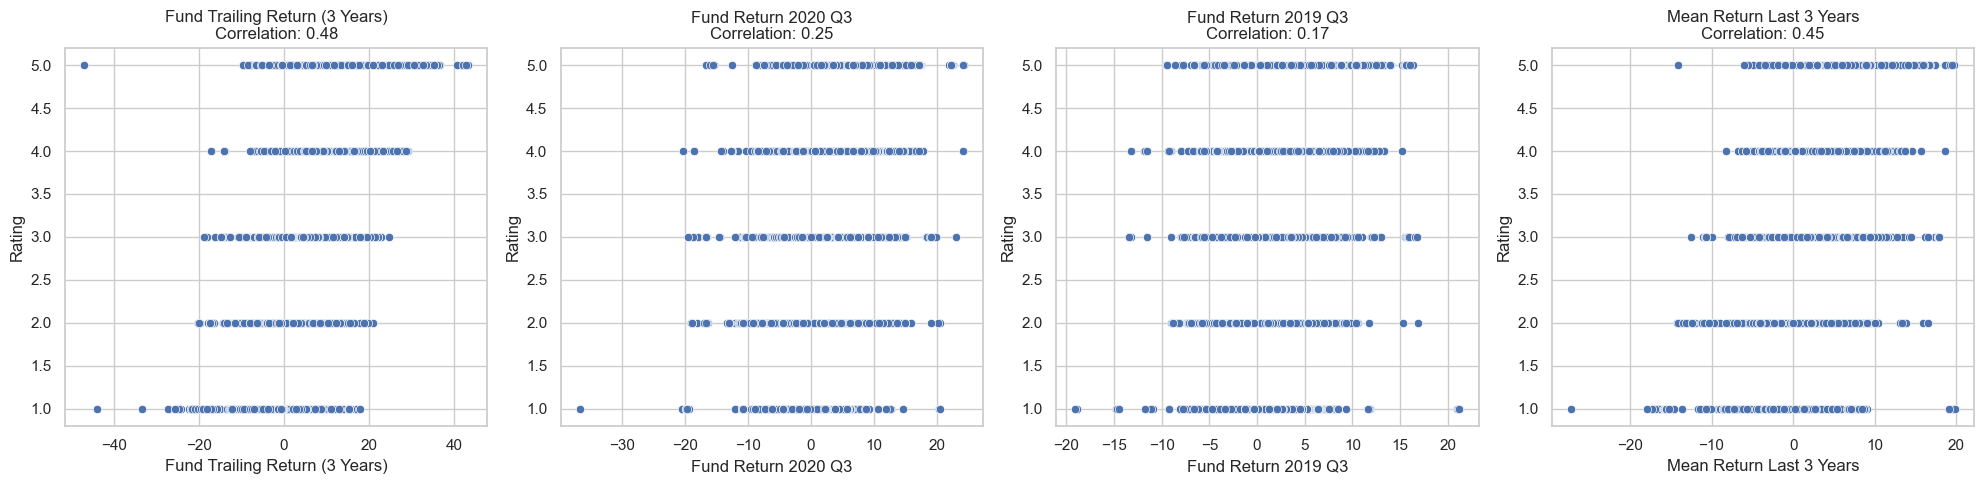

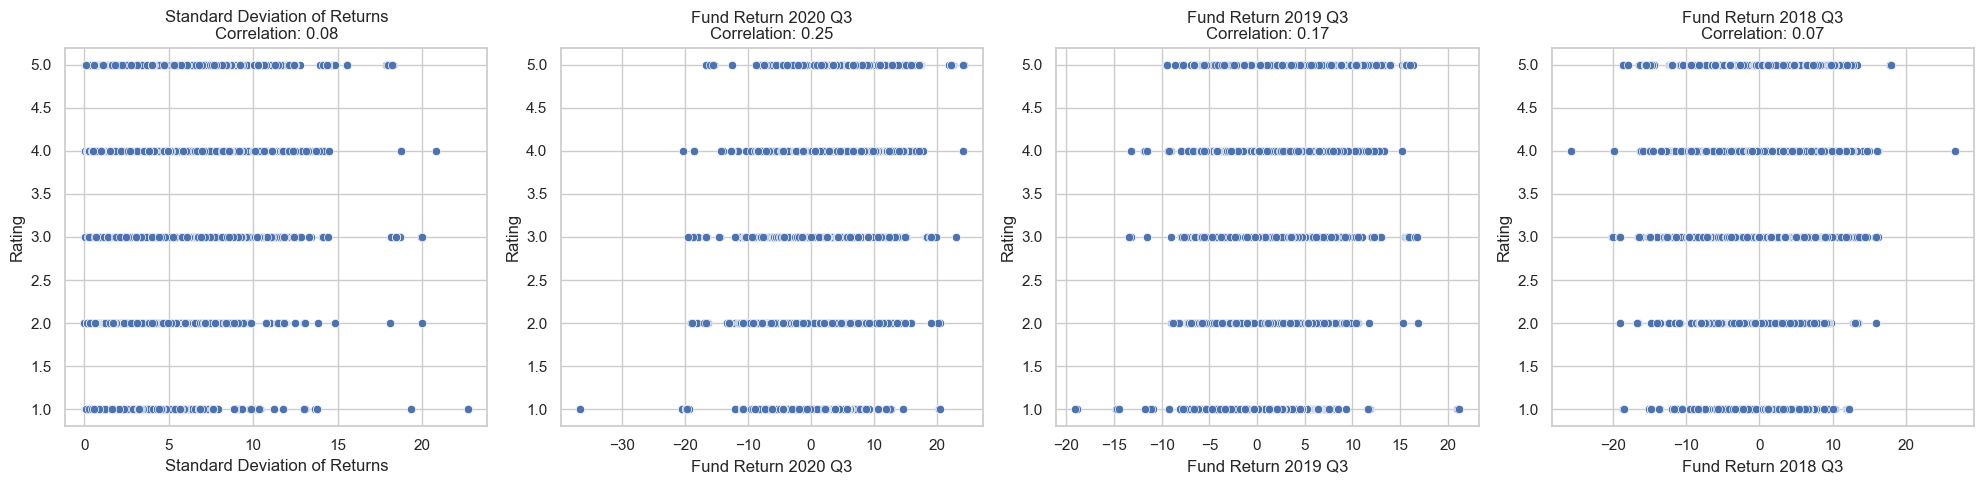

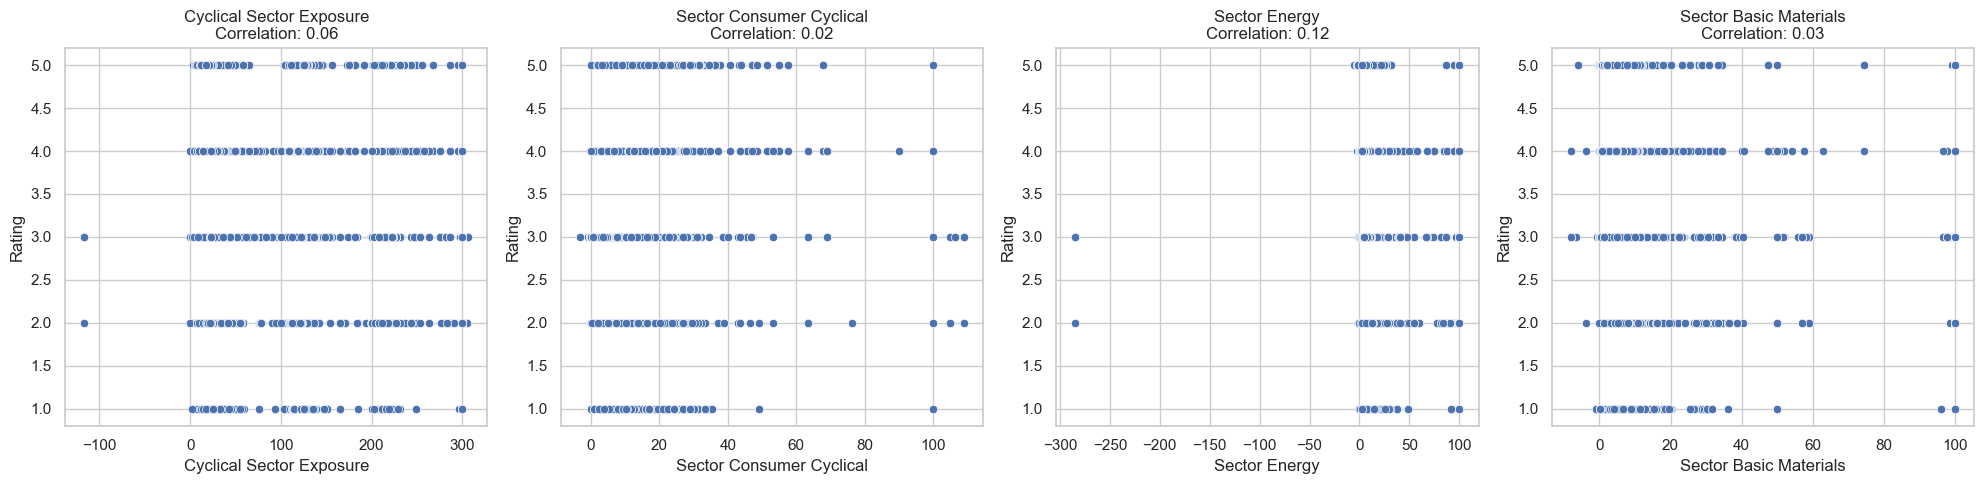

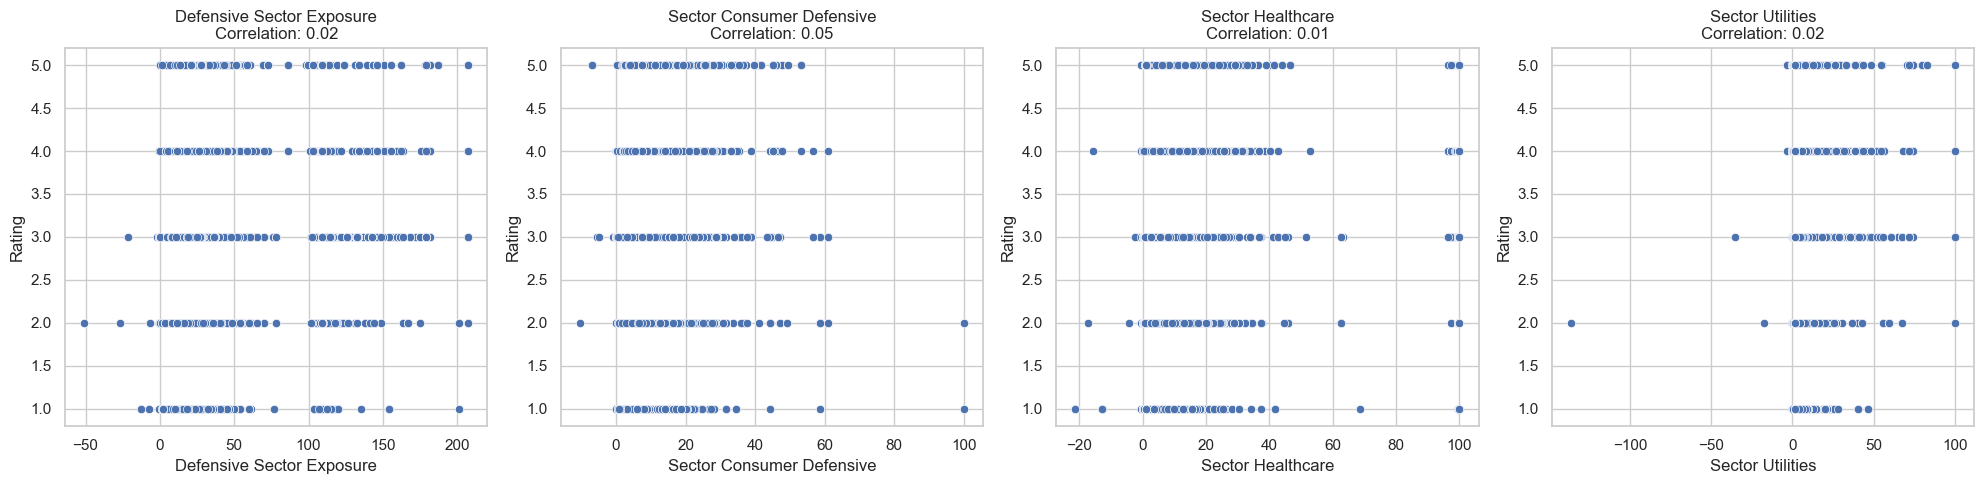

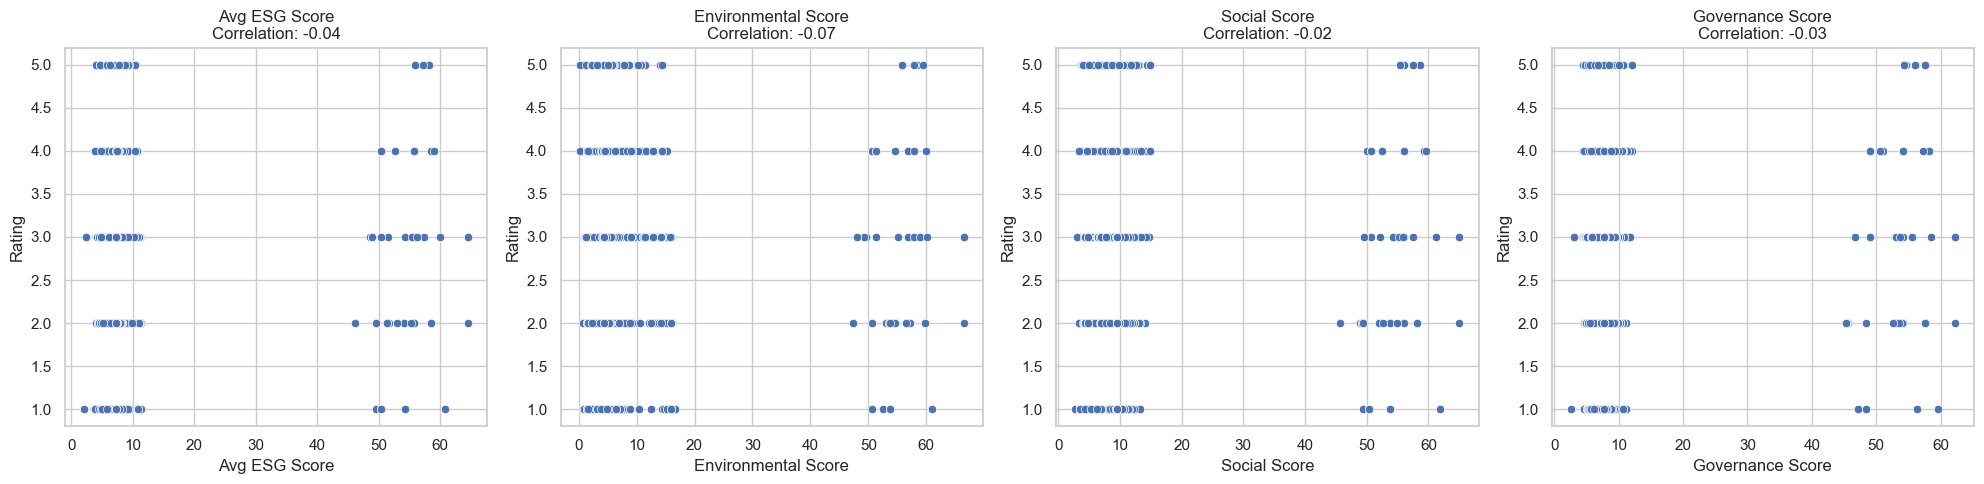

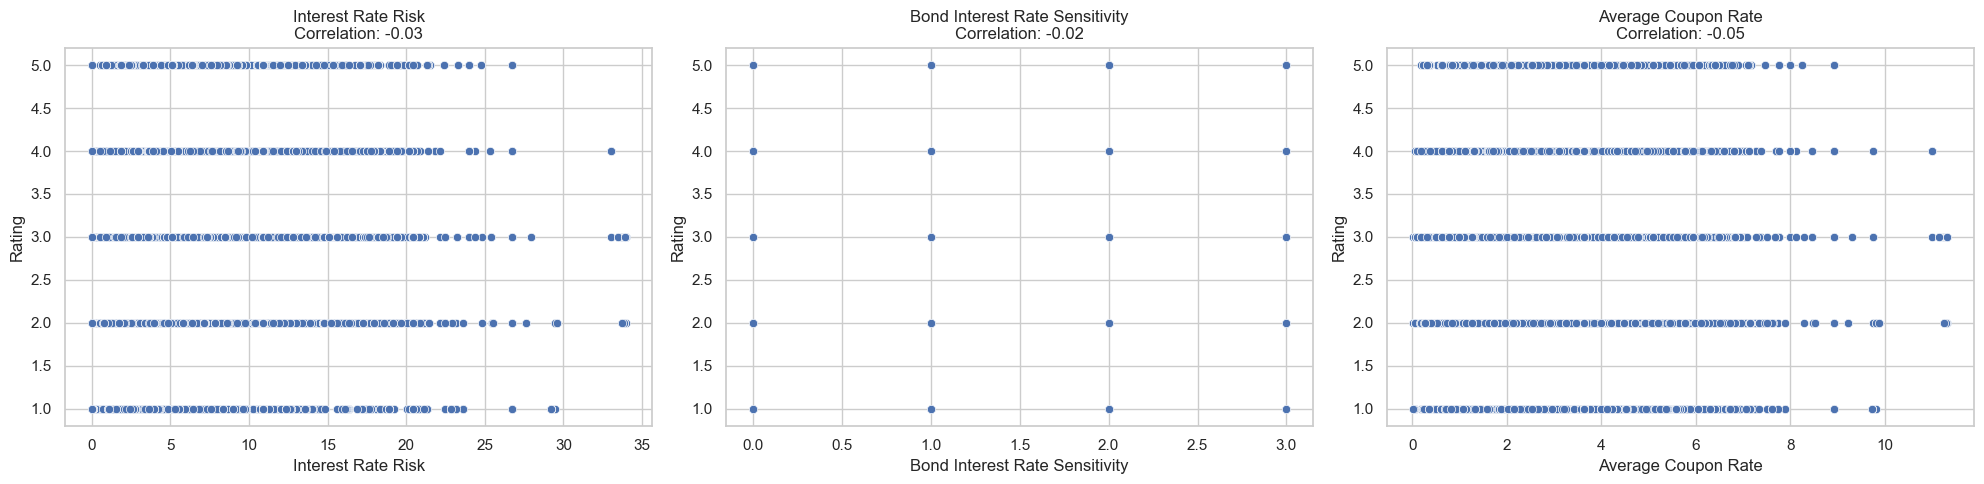

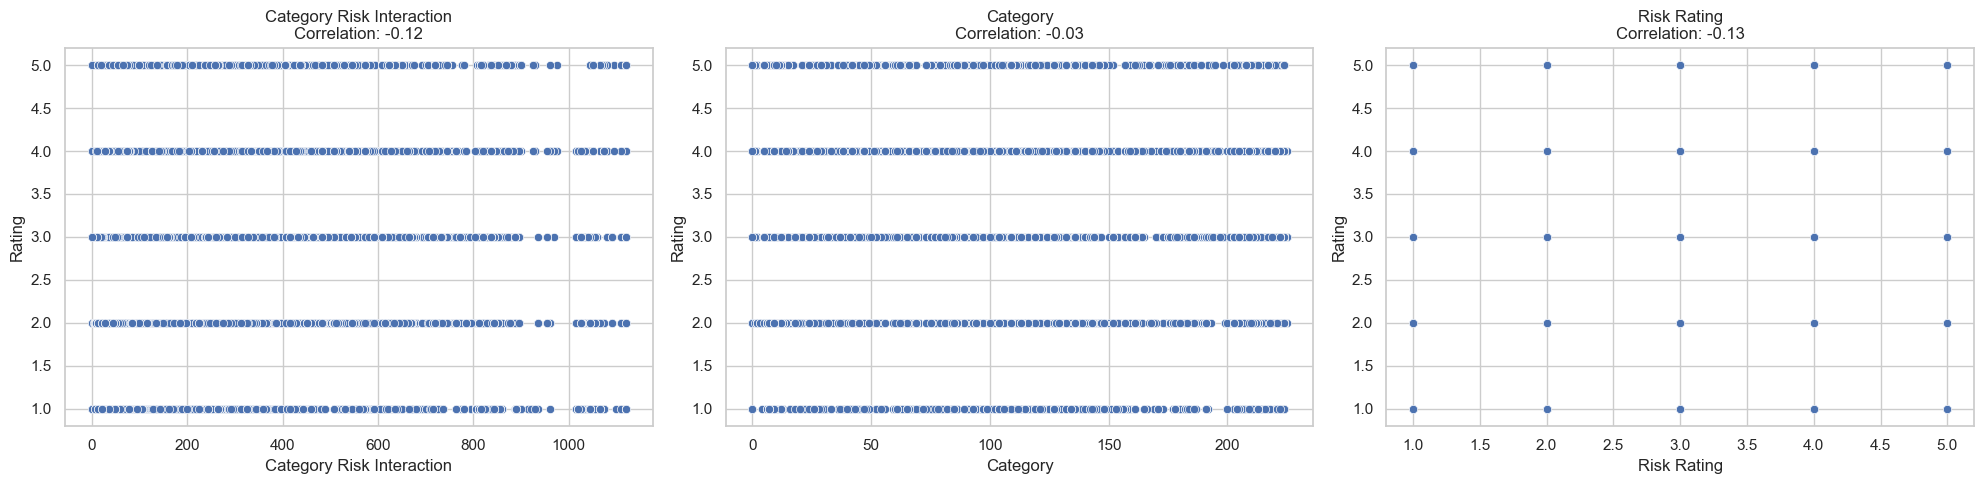

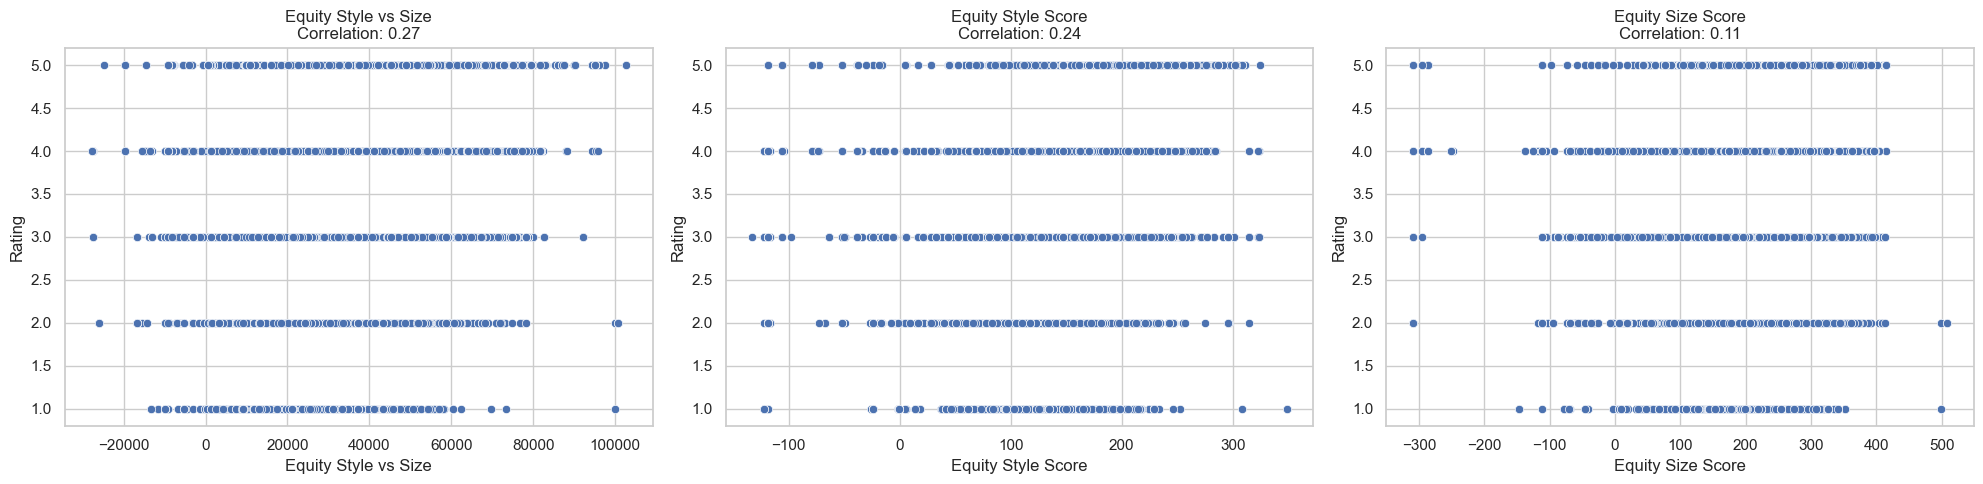

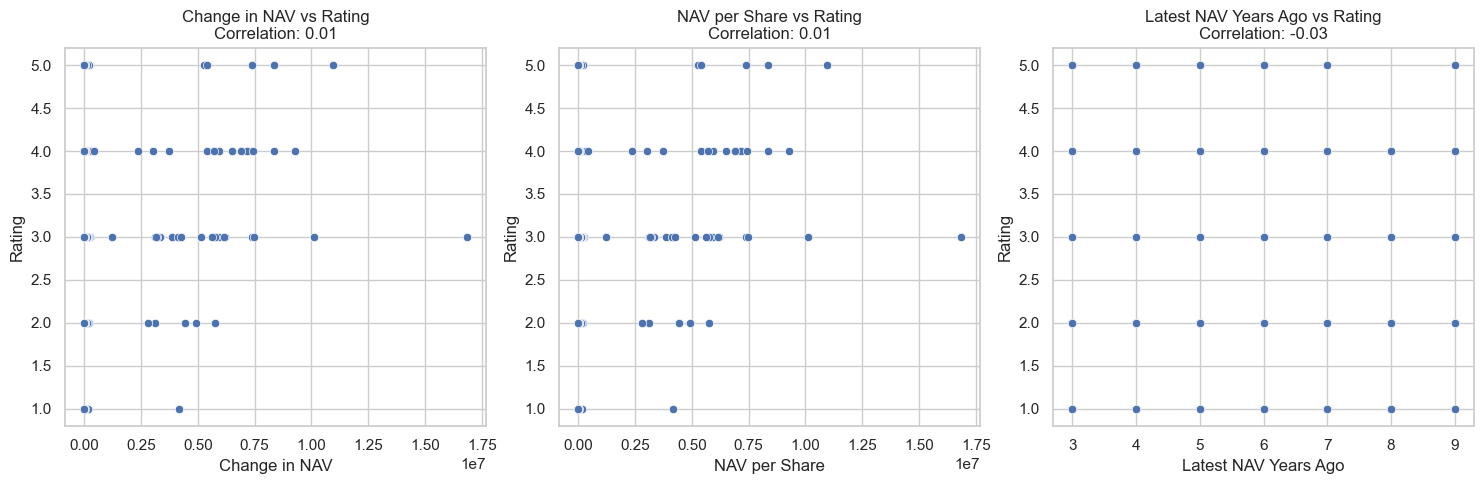

In [490]:
sns.set(style="whitegrid")

def create_scatter_plots(data, variables, titles):
    correlations = [data[var].corr(data['rating']) for var in variables]

    plt.figure(figsize=(20, 5))

    for i, var in enumerate(variables):
        plt.subplot(1, len(variables), i + 1)
        sns.scatterplot(x=data[var], y=data['rating'])
        plt.title(f'{titles[i]}\nCorrelation: {correlations[i]:.2f}')
        plt.xlabel(titles[i])
        plt.ylabel('Rating')

    plt.tight_layout()
    plt.show()

variables_trailing = ['fund_trailing_return_3years', 'fund_return_2020_q3', 
                      'fund_return_2019_q3', 'mean_return_last_3years']
titles_trailing = ['Fund Trailing Return (3 Years)', 'Fund Return 2020 Q3', 
                   'Fund Return 2019 Q3', 'Mean Return Last 3 Years']
create_scatter_plots(data, variables_trailing, titles_trailing)

variables_std_dev = ['std_dev_returns', 'fund_return_2020_q3', 
                     'fund_return_2019_q3', 'fund_return_2018_q3']
titles_std_dev = ['Standard Deviation of Returns', 'Fund Return 2020 Q3', 
                  'Fund Return 2019 Q3', 'Fund Return 2018 Q3']
create_scatter_plots(data, variables_std_dev, titles_std_dev)

variables_cyclical = ['cyclical_sector_exposure', 'sector_consumer_cyclical', 
                      'sector_energy', 'sector_basic_materials']
titles_cyclical = ['Cyclical Sector Exposure', 'Sector Consumer Cyclical', 
                   'Sector Energy', 'Sector Basic Materials']
create_scatter_plots(data, variables_cyclical, titles_cyclical)

variables_defensive = ['defensive_sector_exposure', 'sector_consumer_defensive', 
                       'sector_healthcare', 'sector_utilities']
titles_defensive = ['Defensive Sector Exposure', 'Sector Consumer Defensive', 
                    'Sector Healthcare', 'Sector Utilities']
create_scatter_plots(data, variables_defensive, titles_defensive)

variables_esg = ['avg_esg_score', 'environmental_score', 
                  'social_score', 'governance_score']
titles_esg = ['Avg ESG Score', 'Environmental Score', 
               'Social Score', 'Governance Score']
create_scatter_plots(data, variables_esg, titles_esg)

variables_interest = ['interest_rate_risk', 'bond_interest_rate_sensitivity', 
                      'average_coupon_rate']
titles_interest = ['Interest Rate Risk', 'Bond Interest Rate Sensitivity', 
                   'Average Coupon Rate']
create_scatter_plots(data, variables_interest, titles_interest)

variables_risk = ['category_risk_interaction', 'category', 'risk_rating']
titles_risk = ['Category Risk Interaction', 'Category', 'Risk Rating']
create_scatter_plots(data, variables_risk, titles_risk)

variables_equity = ['equity_style_vs_size', 'equity_style_score', 
                    'equity_size_score']
titles_equity = ['Equity Style vs Size', 'Equity Style Score', 'Equity Size Score']
create_scatter_plots(data, variables_equity, titles_equity)

correlation_change_in_nav = data['change_in_nav'].corr(data['rating'])
correlation_nav_per_share = data['nav_per_share'].corr(data['rating'])
correlation_latest_nav_years_ago = data['latest_nav_years_ago'].corr(data['rating'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=data['change_in_nav'], y=data['rating'])
plt.title(f'Change in NAV vs Rating\nCorrelation: {correlation_change_in_nav:.2f}')
plt.xlabel('Change in NAV')
plt.ylabel('Rating')

plt.subplot(1, 3, 2)
sns.scatterplot(x=data['nav_per_share'], y=data['rating'])
plt.title(f'NAV per Share vs Rating\nCorrelation: {correlation_nav_per_share:.2f}')
plt.xlabel('NAV per Share')
plt.ylabel('Rating')

plt.subplot(1, 3, 3)
sns.scatterplot(x=data['latest_nav_years_ago'], y=data['rating'])
plt.title(f'Latest NAV Years Ago vs Rating\nCorrelation: {correlation_latest_nav_years_ago:.2f}')
plt.xlabel('Latest NAV Years Ago')
plt.ylabel('Rating')

plt.tight_layout()
plt.show()

From the graphs we observe how the new features we created have an overall positive impact on our Target variable which we measure through correrelation. Hence we can continue with dropping the original features.

In [ ]:

columns_to_drop = [
    'fund_trailing_return_3years', 'fund_return_2020_q3', 'fund_return_2019_q3', 'fund_return_2018_q3',
    'sector_consumer_cyclical', 'sector_energy', 'sector_basic_materials', 'sector_consumer_defensive',
    'sector_healthcare', 'sector_utilities', 'market_cap_giant', 'market_cap_large', 'market_cap_medium',
    'market_cap_small', 'market_cap_micro', 'price_prospective_earnings', 'long_term_projected_earnings_growth',
    'price_cash_flow_ratio', 'cash_flow_growth', 'environmental_score', 'social_score', 'governance_score',
    'asset_stock', 'asset_bond', 'asset_cash', 'asset_other', 'bond_interest_rate_sensitivity',
    'average_coupon_rate', 'bond_credit_quality', 'equity_style_score', 'equity_size_score', 'top5_holdings',
    'top5_regions', 'fund_size_usd', 'nav_per_share', 'latest_nav_years_ago'
]

data = data.drop(columns=columns_to_drop)

Capping the values that are outside the Inter-Quartile range of each column

In [260]:
columns_to_cap = [
    'risk_rating', 'price_book_ratio', 'price_sales_ratio',
    'dividend_yield_factor', 'historical_earnings_growth',
    'sales_growth', 'book_value_growth', 'roa', 'roe', 'roic', 'holdings_n_stock', 'ongoing_cost',
    'management_fees', 'sustainability_score',
    'quarters_up', 'quarters_down', 'age',
]

def cap_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

data = cap_outliers(data, columns_to_cap)

In [261]:
data.head()

,fund_name,category,rating,risk_rating,investment_strategy,investment_managers,dividend_frequency,equity_size,price_book_ratio,price_sales_ratio,...,esg_variability,stock_bond_ratio,cash_total_assets_ratio,interest_rate_risk,category_risk_interaction,equity_style_vs_size,top5_holdings_diversity,regional_exposure_diversity,fund_size_per_year,change_in_nav
0,20030,89,5.0,3.0,1738,1435,4,2,0.51,1.070,...,2.555784,0.0,0.108911,0.00,267.0,704.6827,3345,4464,5.392265e+07,41.63
1,28596,210,2.0,3.0,288,342,4,0,3.23,2.745,...,4.261033,inf,0.002200,10.89,630.0,62386.8635,690,2440,1.722958e+07,24.93
2,11913,143,2.0,1.0,5040,3575,0,0,0.72,0.420,...,2.237618,inf,-0.000700,10.89,143.0,24911.4040,4003,1554,1.477125e+06,8.49
3,7146,128,2.0,2.0,194,2679,4,0,2.80,2.680,...,3.073586,inf,0.069300,10.89,256.0,48848.0640,5050,3160,2.994475e+07,28.52
5,20037,128,4.0,1.0,1741,599,4,0,3.23,2.745,...,3.813402,inf,-0.001700,10.89,128.0,46599.4060,4341,4044,8.499535e+08,18429.17


In [262]:
len(data)

31174

Choosing column pairs that have more than 85% absolute correlation 

In [263]:
correlation_matrix = data.corr()

high_correlation_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:  
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

high_correlation_df = pd.DataFrame(high_correlation_pairs, columns=['Column 1', 'Column 2', 'Correlation'])

print(high_correlation_df)

                         Column 1                   Column 2  Correlation
0                             roe                        roa     0.859472
1                            roic                        roa     0.851264
2                 management_fees               ongoing_cost     0.868824
3  sustainability_percentage_rank        sustainability_rank    -0.910148
4        cyclical_sector_exposure  sector_financial_services     0.873981
5       defensive_sector_exposure  sector_financial_services     0.859738
6       defensive_sector_exposure   cyclical_sector_exposure     0.854781


Now finding principal component of each pair of columns and adding it to dataframe while removing the original pair from data to reduce number of features

In [264]:
correlation_pairs = [
    ('roe', 'roa'),
    ('roic', 'roa'),
    ('sector_technology', 'sector_financial_services'),
    ('management_fees', 'ongoing_cost'),
    ('sustainability_percentage_rank', 'sustainability_rank'),
    ('cyclical_sector_exposure', 'sector_financial_services'),
    ('cyclical_sector_exposure', 'sector_technology'),
    ('defensive_sector_exposure', 'sector_financial_services'),
    ('defensive_sector_exposure', 'cyclical_sector_exposure')
]

pca_results = pd.DataFrame(index=data.index)

for col1, col2 in correlation_pairs:
    
    data_subset = data[[col1, col2]].dropna()

    subset_index = data_subset.index

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_subset)
    
    pca = PCA(n_components=1)  
    principal_component = pca.fit_transform(scaled_data)
    
    pca_df = pd.DataFrame(principal_component, index=subset_index, columns=[f'{col1}_{col2}_PCA'])
    
    pca_results = pd.concat([pca_results, pca_df], axis=1)

combined_data = pd.concat([data.drop(columns=[col for pair in correlation_pairs for col in pair]), pca_results], axis=1)

combined_data.head()

,fund_name,category,rating,risk_rating,investment_strategy,investment_managers,dividend_frequency,equity_size,price_book_ratio,price_sales_ratio,...,change_in_nav,roe_roa_PCA,roic_roa_PCA,sector_technology_sector_financial_services_PCA,management_fees_ongoing_cost_PCA,sustainability_percentage_rank_sustainability_rank_PCA,cyclical_sector_exposure_sector_financial_services_PCA,cyclical_sector_exposure_sector_technology_PCA,defensive_sector_exposure_sector_financial_services_PCA,defensive_sector_exposure_cyclical_sector_exposure_PCA
0,20030,89,5.0,3.0,1738,1435,4,2,0.51,1.070,...,41.63,-1.392795,-2.704398,0.954609,-1.211274,-0.047018,1.881648,0.927039,1.804321,1.811141
1,28596,210,2.0,3.0,288,342,4,0,3.23,2.745,...,24.93,2.135269,1.967110,-1.760259,1.637933,0.652571,0.004330,1.764590,-1.134224,-0.256960
2,11913,143,2.0,1.0,5040,3575,0,0,0.72,0.420,...,8.49,-2.530727,-2.485619,-0.243659,-1.163893,-0.619409,-1.195512,-0.951853,-1.279163,-1.309874
3,7146,128,2.0,2.0,194,2679,4,0,2.80,2.680,...,28.52,0.563109,0.401814,-0.742477,1.475496,0.016581,-1.237934,-0.495457,-0.956503,-1.110270
5,20037,128,4.0,1.0,1741,599,4,0,3.23,2.745,...,18429.17,1.621990,0.889199,-1.159170,1.316304,2.703484,-0.256651,0.902518,-0.631383,0.402543


Removing NaN values if any

In [265]:
if np.any(np.isnan(combined_data)) or np.any(np.isinf(combined_data)):    
    combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_data.fillna(combined_data.mean(), inplace=True)

In [266]:
combined_data.head()

,fund_name,category,rating,risk_rating,investment_strategy,investment_managers,dividend_frequency,equity_size,price_book_ratio,price_sales_ratio,...,change_in_nav,roe_roa_PCA,roic_roa_PCA,sector_technology_sector_financial_services_PCA,management_fees_ongoing_cost_PCA,sustainability_percentage_rank_sustainability_rank_PCA,cyclical_sector_exposure_sector_financial_services_PCA,cyclical_sector_exposure_sector_technology_PCA,defensive_sector_exposure_sector_financial_services_PCA,defensive_sector_exposure_cyclical_sector_exposure_PCA
0,20030,89,5.0,3.0,1738,1435,4,2,0.51,1.070,...,41.63,-1.392795,-2.704398,0.954609,-1.211274,-0.047018,1.881648,0.927039,1.804321,1.811141
1,28596,210,2.0,3.0,288,342,4,0,3.23,2.745,...,24.93,2.135269,1.967110,-1.760259,1.637933,0.652571,0.004330,1.764590,-1.134224,-0.256960
2,11913,143,2.0,1.0,5040,3575,0,0,0.72,0.420,...,8.49,-2.530727,-2.485619,-0.243659,-1.163893,-0.619409,-1.195512,-0.951853,-1.279163,-1.309874
3,7146,128,2.0,2.0,194,2679,4,0,2.80,2.680,...,28.52,0.563109,0.401814,-0.742477,1.475496,0.016581,-1.237934,-0.495457,-0.956503,-1.110270
5,20037,128,4.0,1.0,1741,599,4,0,3.23,2.745,...,18429.17,1.621990,0.889199,-1.159170,1.316304,2.703484,-0.256651,0.902518,-0.631383,0.402543


In [267]:
combined_data.shape

(31174, 93)

## Classification

In [268]:
combined_data = combined_data.sample(frac = 1)

## RandomForest SMOTE

In [269]:
X = combined_data.drop('rating', axis=1)
y = combined_data['rating']

In [270]:
smote_params = {
    'sampling_strategy': 'auto',
    'random_state': 77,
    'n_jobs': -1
}

smote = SMOTE(**smote_params)

X_smote, y_smote = smote.fit_resample(X,y)

c:\Users\Paarth\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [271]:
X_train_full_smote, X_test_smote, y_train_full_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.1, random_state=42)
X_train_smote, X_val_smote, y_train_smote, y_val_smote = train_test_split(X_train_full_smote,y_train_full_smote, test_size=0.1111, random_state=42)

In [272]:

X = combined_data.drop('rating', axis=1)
y = combined_data['rating']
smote_params = {
    'sampling_strategy': 'auto',
    'random_state': 77,
    'n_jobs': -1
}

smote = SMOTE(**smote_params)

X_smote, y_smote = smote.fit_resample(X,y)
X_train_full_smote, X_test_smote, y_train_full_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.1, random_state=42)
X_train_smote, X_val_smote, y_train_smote, y_val_smote = train_test_split(X_train_full_smote,y_train_full_smote, test_size=0.1111, random_state=42)


rf_classifier = RandomForestClassifier(n_estimators=800, bootstrap=True, min_samples_split=3,
                                       min_samples_leaf=2, max_features='log2', max_depth=18)

rf_classifier.fit(X_train_smote, y_train_smote)

y_predt = rf_classifier.predict(X_train_smote)
y_predv = rf_classifier.predict(X_val_smote)
y_predte =rf_classifier.predict(X_test_smote)

accuracy_val = accuracy_score(y_val_smote, y_predv)
accuracy_train = accuracy_score(y_train_smote, y_predt)
accuracy_test =accuracy_score(y_test_smote,y_predte)

report = classification_report(y_test_smote, y_predte)

print("Accuracy Val:", accuracy_val)
print("Accuracy Test", accuracy_test)
print("Accuracy train:", accuracy_train)
print("\nClassification Report test:\n", report)


c:\Users\Paarth\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Accuracy Val: 0.8285662889008815
Accuracy Test 0.8338129496402877
Accuracy train: 0.9888479179782355

Classification Report test:
               precision    recall  f1-score   support

         1.0       0.90      0.94      0.92      1127
         2.0       0.82      0.79      0.80      1132
         3.0       0.80      0.80      0.80      1076
         4.0       0.81      0.72      0.76      1146
         5.0       0.83      0.92      0.87      1079

    accuracy                           0.83      5560
   macro avg       0.83      0.83      0.83      5560
weighted avg       0.83      0.83      0.83      5560



## Random Forest Smoteen

In [273]:
X = combined_data.drop('rating',axis=1)
y = combined_data['rating']

In [274]:
smoteen_params = {
    'sampling_strategy': 'auto',
    'random_state': 77,
    'n_jobs': -1
}

smoteen = SMOTEENN(smote=SMOTE(sampling_strategy='auto', random_state=77, n_jobs=-1),
                    enn=EditedNearestNeighbours(n_neighbors=5))

X_smoteen,y_smoteen = smoteen.fit_resample(X,y)

c:\Users\Paarth\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [275]:
X_train_full_smoteen, X_test_smoteen, y_train_full_smoteen, y_test_smoteen = train_test_split(X_smoteen, y_smoteen, test_size=0.1, random_state=42)
X_train_smoteen, X_val_smoteen, y_train_smoteen, y_val_smoteen = train_test_split(X_train_full_smoteen,y_train_full_smoteen, test_size=0.1111, random_state=42)

In [276]:
rf_classifier = RandomForestClassifier(n_estimators=250, bootstrap=True, min_samples_split=3,min_samples_leaf=2,max_features=35, max_depth=6)
rf_classifier.fit(X_train_smoteen, y_train_smoteen)


y_predt_smoteen = rf_classifier.predict(X_train_smoteen)
y_predv_smoteen = rf_classifier.predict(X_val_smoteen)
y_predte_smoteen = rf_classifier.predict(X_test_smoteen)

accuracy_val = accuracy_score(y_val_smoteen, y_predv_smoteen)
accuracyt = accuracy_score(y_train_smoteen, y_predt_smoteen)
accuracyte = accuracy_score(y_test_smoteen,y_predte_smoteen)

report = classification_report(y_test_smoteen, y_predte_smoteen)



print("Accuracy val:", accuracy_val)
print("Accuracy train:", accuracyt)
print("Accuracy test:", accuracyte)
print("\nClassification Report test:\n", report)


Accuracy val: 0.9169755374351372
Accuracy train: 0.9231482339853527
Accuracy test: 0.9221645663454411

Classification Report test:
               precision    recall  f1-score   support

         1.0       0.92      1.00      0.96      1121
         2.0       1.00      0.06      0.12        62
         3.0       1.00      0.54      0.70        13
         4.0       1.00      0.04      0.07        27
         5.0       0.89      0.88      0.88       126

    accuracy                           0.92      1349
   macro avg       0.96      0.50      0.55      1349
weighted avg       0.93      0.92      0.89      1349



## XGBoost Smoteen

In [281]:
X_boost = combined_data.drop('rating', axis=1)
y_boost = combined_data['rating']

y_boost = y_boost - 1

X_smoteen_boost, y_smoteen_boost = smoteen.fit_resample(X_boost, y_boost)

c:\Users\Paarth\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [282]:
X_train_full_smoteen_boost, X_test_smoteen_boost, y_train_full_smoteen_boost, y_test_smoteen_boost = train_test_split(X_smoteen_boost, y_smoteen_boost, test_size=0.1, random_state=42)
X_train_smoteen_boost, X_val_smoteen_boost, y_train_smoteen_boost, y_val_smoteen_boost = train_test_split(X_train_full_smoteen_boost,y_train_full_smoteen_boost, test_size=0.1111, random_state=42)

In [283]:
xgb_classifier = XGBClassifier( n_estimators=230,          
    max_depth=2,               
    learning_rate=0.1,         
    subsample=0.8,             
    colsample_bytree=0.8,      
    random_state=77,
    n_jobs=-1)

xgb_classifier.fit(X_train_smoteen_boost, y_train_smoteen_boost)


y_predt_smoteen_boost = xgb_classifier.predict(X_train_smoteen_boost)
y_predv_smoteen_boost = xgb_classifier.predict(X_val_smoteen_boost)
y_predte_smoteen_boost = xgb_classifier.predict(X_test_smoteen_boost)

accuracy_val_boost = accuracy_score(y_val_smoteen_boost, y_predv_smoteen_boost)
accuracyt_boost = accuracy_score(y_train_smoteen_boost, y_predt_smoteen_boost)
accuracyte_boost = accuracy_score(y_test_smoteen_boost,y_predte_smoteen_boost)

report = classification_report(y_test_smoteen_boost, y_predte_smoteen_boost)

print("Accuracy val:", accuracy_val_boost)
print("Accuracy train:", accuracyt_boost)
print("Accuracy test:", accuracyte_boost)

print("\nClassification Report test:\n", report)




Accuracy val: 0.9399555226093402
Accuracy train: 0.9561509224066005
Accuracy test: 0.9473684210526315

Classification Report test:
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      1121
         1.0       0.85      0.27      0.41        62
         2.0       1.00      0.85      0.92        13
         3.0       0.69      0.33      0.45        27
         4.0       0.92      0.96      0.94       126

    accuracy                           0.95      1349
   macro avg       0.88      0.68      0.74      1349
weighted avg       0.94      0.95      0.94      1349



## LightGBM Smoteen

In [284]:
X_light = combined_data.drop('rating', axis=1)
y_light = combined_data['rating']

y_light = y_light - 1

X_smoteen_light, y_smoteen_light = smoteen.fit_resample(X_light, y_light)


c:\Users\Paarth\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [285]:
X_train_full_smoteen_light, X_test_smoteen_light, y_train_full_smoteen_light, y_test_smoteen_light = train_test_split(X_smoteen_light, y_smoteen_light, test_size=0.1, random_state=42)
X_train_smoteen_light, X_val_smoteen_light, y_train_smoteen_light, y_val_smoteen_light = train_test_split(X_train_full_smoteen_light,y_train_full_smoteen_light, test_size=0.1111, random_state=42)

In [286]:
lgbm_classifier = LGBMClassifier(
    n_estimators=230,            
    max_depth=2,                 
    learning_rate=0.1,           
    subsample=0.8,               
    colsample_bytree=0.8,        
    random_state=77,
    n_jobs=-1,
    
)

lgbm_classifier.fit(X_train_smoteen_light, y_train_smoteen_light)


y_predt_smoteen_light = lgbm_classifier.predict(X_train_smoteen_light)
y_predv_smoteen_light = lgbm_classifier.predict(X_val_smoteen_light)
y_predte_smoteen_light = lgbm_classifier.predict(X_test_smoteen_light)

accuracy_val_light = accuracy_score(y_val_smoteen_light, y_predv_smoteen_light)
accuracyt_light = accuracy_score(y_train_smoteen_light, y_predt_smoteen_light)
accuracyte_light = accuracy_score(y_test_smoteen_light,y_predte_smoteen_light)

report_light = classification_report(y_test_smoteen_light, y_predte_smoteen_light)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22210
[LightGBM] [Info] Number of data points in the train set: 10787, number of used features: 92
[LightGBM] [Info] Start training from score -0.194653
[LightGBM] [Info] Start training from score -2.935211
[LightGBM] [Info] Start training from score -4.622658
[LightGBM] [Info] Start training from score -3.977829
[LightGBM] [Info] Start training from score -2.351700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [287]:
print("Accuracy val:", accuracy_val_light)
print("Accuracy train:", accuracyt_light)
print("Accuracy test:", accuracyte_light)
print("\nClassification Report test:\n", report_light)

Accuracy val: 0.9429206819866568
Accuracy train: 0.9722814498933902
Accuracy test: 0.9518161601186064

Classification Report test:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1121
         1.0       0.96      0.35      0.52        62
         2.0       1.00      0.92      0.96        13
         3.0       0.64      0.33      0.44        27
         4.0       0.92      0.96      0.94       126

    accuracy                           0.95      1349
   macro avg       0.90      0.71      0.77      1349
weighted avg       0.95      0.95      0.94      1349



### Insights

INSIGHTS-:

1.	The dataset had a large number of features, including various financial ratios, ESG factors, and historical returns. Feature selection and dimensionality reduction via PCA  was critical for effective modelling.

2.	The rating distribution was imbalanced, with some ratings underrepresented. Addressing this imbalance through techniques like SMOTE was essential. 

3.	SMOTE and SMOTEEN are both techniques used to address the issue of class imbalance in datasets. SMOTE does not change the majority class and does not address the issue of potential "noise" in the majority class. y combining the generation of synthetic minority examples (SMOTE) with the removal of noisy samples (ENN), SMOTEEN can help to create a more distinct and accurate decision boundary between the minority and majority classes.

4.	A variety of interactions (e.g., between category, risk, sustainability) influence the ratings, requiring careful modeling of non-linear relationships.

### Pseudocodes

We tried SMOTE because values in Ratings columns were not balanced.

SMOTE(X, y, k):

    Initialize synthetic_samples = []

    minority_class, majority_class = IdentifyClasses(y)

    minority_instances = GetInstances(X, y, minority_class)

    FOR instance in minority_instances:
        neighbors = FindKNearestNeighbors(instance, X, k)

        FOR i from 1 to k:
        
            neighbor = RandomSelect(neighbors)

            synthetic_sample = instance + RandomNumber(0, 1) * (neighbor - instance)

            synthetic_samples.append(synthetic_sample)

    X_augmented = Concatenate(X, synthetic_samples)
    y_augmented = Concatenate(y, [minority_class] * len(synthetic_samples))

    RETURN X_augmented, y_augmented
END

SMOTE and SMOTEEN are both techniques used to address the issue of class imbalance in datasets. SMOTE does not change the majority class and does not address the issue of potential "noise" in the majority class. y combining the generation of synthetic minority examples (SMOTE) with the removal of noisy samples (ENN), SMOTEEN can help to create a more distinct and accurate decision boundary between the minority and majority classes

BEGIN

SMOTEENN(X, y, sampling_strategy, random_state):

    smote = InitializeSMOTE(sampling_strategy, random_state)
    enn = InitializeENN()

    X_resampled, y_resampled = smote.Generate(X, y)

    X_final, y_final = enn.Clean(X_resampled, y_resampled)

    RETURN X_final, y_final
END

Pseudocode for the selected models

BEGIN

RandomForestClassifier(X, y, num_trees, max_features, max_depth):
    Initialize forest = []

    FOR i in range(num_trees):

        X_sample, y_sample = BootstrapSample(X, y)

        tree = BuildDecisionTree(X_sample, y_sample, max_features, max_depth)

        forest.append(tree)

    DEFINE Predict(X_new):
        predictions = []

        FOR tree in forest:
            pred = tree.Predict(X_new)
            predictions.append(pred)

        final_prediction = Mean(predictions)
        RETURN final_prediction
    END

    RETURN Predict
END

BEGIN

XGBoostClassifier(X, y, num_trees, learning_rate, max_depth):
    Initialize weights for all samples as 1/n (where n is the number of samples)
    Initialize final_predictions = 0

    FOR i in range(num_trees):
        # Train weak learner (tree) on weighted data
        tree = TrainDecisionTree(X, y, weights, max_depth)

        # Predict with the trained tree
        predictions = tree.Predict(X)

        # Compute residuals (error)
        residuals = y - predictions

        # Update final_predictions by adding learning_rate * predictions
        final_predictions += learning_rate * predictions

        # Update weights based on residuals (boosting process)
        weights = UpdateWeights(residuals, weights)

    DEFINE Predict(X_new):
        # Initialize final prediction for new data
        final_prediction = 0

        FOR tree in forest:
            pred = tree.Predict(X_new)
            final_prediction += learning_rate * pred

        RETURN final_prediction (after applying sigmoid or softmax for classification)
    END

    RETURN Predict
END

BEGIN

LightGBM(X, y, num_iterations, learning_rate, max_depth, num_leaves, feature_fraction):
    Initialize model = []
    
    predictions = InitializePredictions(X)

    FOR iteration in range(num_iterations):

        gradients, hessians = ComputeGradientsAndHessians(y, predictions)

        tree = TrainDecisionTree(X, gradients, hessians, max_depth, num_leaves, feature_fraction)

        tree_predictions = tree.Predict(X)

        predictions += learning_rate * tree_predictions

        # Optionally: Update the model with the new tree
        model.append(tree)

    RETURN model, predictions

END

### References

Dataset Source: https://www.kaggle.com/datasets/stefanoleone992/european-funds-dataset-from-morningstar

www.scikit-learn.org

Research: https://www.etmoney.com/learn/mutual-funds/annual-vs-trailing-vs-rolling-returns-meaning-calculation-importance/
          https://www.sustainalytics.com/investor-solutions/analytic-reporting-solutions/morningstar-sustainability-rating-for-funds
          https://ratingagency.morningstar.com/PublicDocDisplay.aspx?i=%2b7cwsQ2XW8A%3d&m=i0Pyc%2bx7qZZ4%2bsXnymazBA%3d%3d&s=LviRtUKXqs8kml5dHt7FTeE2SZmY0Fvqd4iX49Mk%2f9UapyiFTEO6TA%3d%3d#:~:text=AAA%20A%20rating%20of%20AAA,final%20distribution%20or%20maturity%20date